# GMM for multivariate data and learning all parameters


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys,time

In [248]:
####################
####################
#  gibbs sampling  #
####################
####################
def gibbs_gmm(y,mu0,sigma0,w0,steps,burnin_pct,seed=0):
    """
    Run a Gibbs sampler for the labels x, weights w,
    means mu, and covariance matrices sigma of
    a Gaussian mixture model with obsevations
    yn~sum_k wk Gaussian(muk,sigmak), n=1,...,N

    Inputs:
        y          : (N,d) array, observations (N is no. of obs, d is dimension of each obs)
        mu0        : (K,d) array, initial means (K is number of clusters)
        sigma0     : (K,d,d) array, initial covariances
        w0         : (K,) array, initial weights
        steps      : int, number of steps to run the sampler from (after burn-in)
        burnin_pct : float, percentage of burn-in desired
        seed       : int, random seed

     Outputs:
         xs        : (steps,N) array, labels samples
         ws        : (steps,K) array, weights samples
         mus       : (steps,K,d) array, means samples
         sigmas    : (steps,K,d,d) array, covariance matrices samples

    Note: the total number of steps the sampler is run for is
          (T=steps+burn_in), where (burn_in=T*burnin_pct).
          The total burn-in steps is therefore
          (steps*burnin_pct/(1-burnin_pct))
    """
    np.random.seed(0+seed)
    
    # get sizes, calculate steps
    N,d=y.shape
    K=mu0.shape[0]
    burnin_steps=int(steps*burnin_pct/(1-burnin_pct))
    total_steps=burnin_steps+steps+1
    
    # init params
    xs=np.zeros((total_steps,N),dtype=int)
    xs[0,:]=np.random.randint(low=0,high=K,size=N)
    ws=np.ones((total_steps,K))/K
    ws[0,:]=w0
    mus=np.zeros((total_steps,K,d))
    mus[0,:,:]=mu0
    sigmas=np.ones((total_steps,K,d,d))
    sigmas[0,:,:,:]=sigma0
    
    for t in range(total_steps-1):
        if t<burnin_steps: print('Burn-in: '+str(t+1)+'/'+str(burnin_steps),end='\r')
        if t>=burnin_steps: print('Sampling: '+str(t+1-burnin_steps)+'/'+str(steps),end='\r')
        
        # update indices ###
        # first obtain log probabilities
        tmplprbs=np.ones((N,K))*np.log(ws[t,:])
        for k in range(K): tmplprbs[:,k]+=stats.multivariate_normal(mus[t,k,:],sigmas[t,k,:,:]).logpdf(y)
        # then sample using gumbel-max trick
        G=np.random.gumbel(size=(N,K))
        tmpx=np.argmax(tmplprbs+G,axis=1)
        xs[t+1,:]=tmpx
        
        # get cluster summaries
        x_tuple=np.zeros((N,K),dtype=int)
        x_tuple[np.arange(N),tmpx]=1
        Nks=np.sum(x_tuple,axis=0)
        
        # update weights ###
        tmpw=np.random.dirichlet(Nks+1)
        ws[t+1,:]=tmpw
        
        # update means and covariances ###
        for k in range(K):
            yk=y[tmpx==k,:] # cluster elements, avg in next line
            
            # update covariance
            Sk=np.cov(yk,rowvar=False) # cluster covariance
            tmpsigma=sigmas[t,k,:,:]
            if np.linalg.cond(Sk) < 1/sys.float_info.epsilon: tmpsigma = stats.invwishart(N-d-2,Sk).rvs() # Sk invertible
            sigmas[t+1,k,:,:]=tmpsigma
            
            # update mean
            mus[t+1,k,:]=np.random.multivariate_normal(np.mean(yk,axis=0),sigmas[t+1,k,:,:])       
        # end for
    # end for
    burnin_steps+=1 # to account for initial draw
    return xs[burnin_steps:,...],ws[burnin_steps:,...],mus[burnin_steps:,...],sigmas[burnin_steps:,...]

## Old Faithful data (test only)

<AxesSubplot: xlabel='eruptions', ylabel='waiting'>

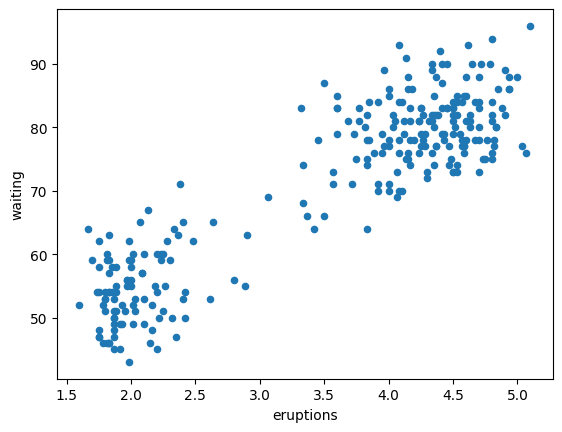

In [4]:
####################
####################
#  data wrangling  #
####################
####################
of_dat=pd.read_table('https://gist.githubusercontent.com/curran/4b59d1046d9e66f2787780ad51a1cd87/raw/9ec906b78a98cf300947a37b56cfe70d01183200/data.tsv')
dat=np.array(of_dat)
of_dat.plot.scatter('eruptions','waiting')

In [95]:
####################
####################
#      setup       #
####################
####################

# settings
K=2
steps=1000
burnin_pct=0.5
d=dat.shape[1]

# initial arrays
mu0=np.array([[2,50],[5,80]])
sigma0=np.zeros((K,2,2))
for k in range(K): sigma0[k,:,:]=5.*np.eye(d)
w0=np.ones(K)/K

In [96]:
####################
####################
#   run sampler    #
####################
####################
xs,ws,mus,sigmas=gibbs_gmm(y=np.array(of_dat),mu0=mu0,sigma0=sigma0,w0=w0,steps=steps,burnin_pct=burnin_pct)

Text(0, 0.5, 'Wait time')

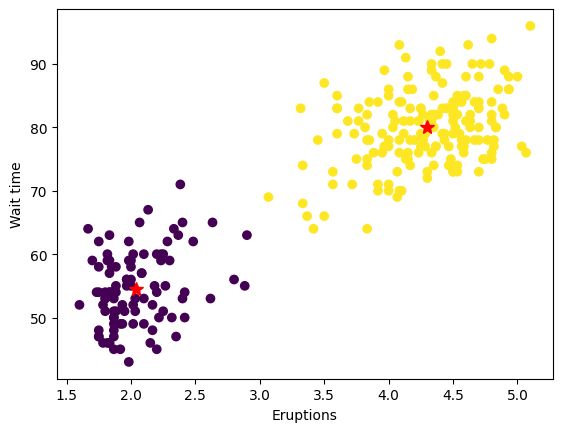

In [97]:
####################
####################
#     results      #
####################
####################
plt.scatter(dat[:,0],dat[:,1],c=xs[-1,:])
plt.plot(mus[-1,0,0],mus[-1,0,1],'*r',ms=10)
plt.plot(mus[-1,1,0],mus[-1,1,1],'*r',ms=10)
plt.xlabel('Eruptions')
plt.ylabel('Wait time')

In [98]:
print('Cluster covariance matrices:')
print(sigmas[-1,...])

Cluster covariance matrices:
[[[0.00023016 0.00142526]
  [0.00142526 0.12571423]]

 [[0.00062358 0.00303278]
  [0.00303278 0.11376388]]]


## Palmer penguin data set

In [307]:
from palmerpenguins import load_penguins
penguins = load_penguins().dropna()

In [308]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [317]:
std_penguins=(penguins-penguins.mean())/penguins.std() # normalize data

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_5425/1641956033.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  std_penguins=(penguins-penguins.mean())/penguins.std()
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_5425/1641956033.py:1: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  std_penguins=(penguins-penguins.mean())/penguins.std()


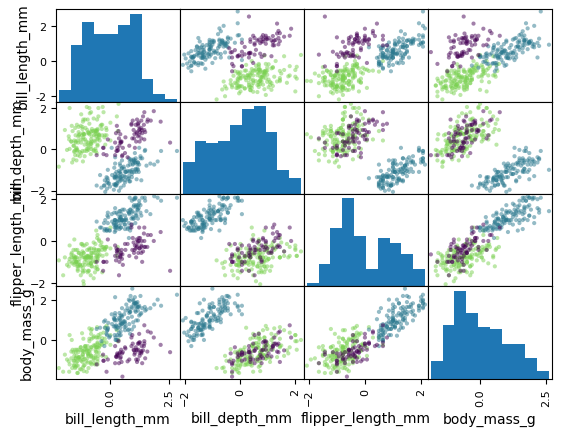

In [318]:
colors=np.squeeze(np.array(penguins[['species']]))
colors[colors=='Adelie']='#7ad151'
colors[colors=='Gentoo']='#2a788e'
colors[colors=='Chinstrap']='#440154'
pd.plotting.scatter_matrix(std_penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=colors);

In [319]:
pg_dat=np.array(std_penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']])

In [337]:
####################
####################
#      setup       #
####################
####################

# settings
K=3
steps=5000
burnin_pct=0.8
d=pg_dat.shape[1]

# initial arrays
#mu0=np.array([[35.,25.,175.,3500.],  # green
#              [55.,17.,200.,4000.],  # purple 
#              [45.,10.,225.,5000.]]) # blue
mu0=np.array([[-2.,1.,-1.,-1.],  # green
             [1.,1.,-0.5,-0.5],  # purple
             [1.,-1.5,1.5,2.]])  # blue
sigma0=np.zeros((K,d,d))
#for k in range(K): sigma0[k,:,:]=np.array([10.,10.,25.,500.]).reshape(d,1)*np.eye(d)
for k in range(K): sigma0[k,:,:]=0.5*np.eye(d)
w0=np.ones(K)/K

In [338]:
####################
####################
#   run sampler    #
####################
####################
#seed=31415926
seed=1
xs,ws,mus,sigmas=gibbs_gmm(y=pg_dat,mu0=mu0,sigma0=sigma0,w0=w0,steps=steps,burnin_pct=burnin_pct,seed=seed)

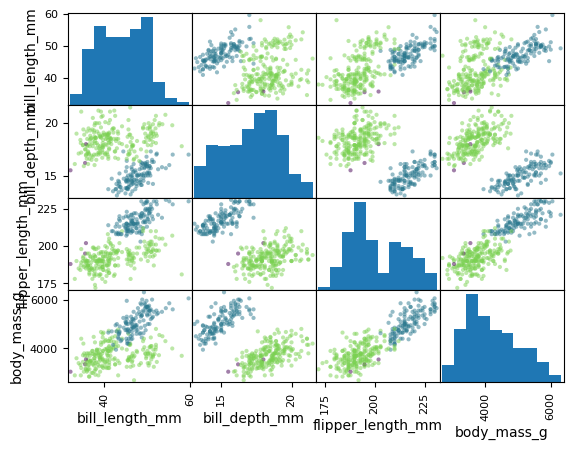

In [339]:
colors[xs[-1,:]==0]='#440154'
colors[xs[-1,:]==1]='#7ad151'
colors[xs[-1,:]==2]='#2a788e'
pd.plotting.scatter_matrix(penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=colors);

## Waveform data set

In [279]:
from sklearn.decomposition import PCA
waveform_dat=pd.read_table('https://hastie.su.domains/ElemStatLearn/datasets/waveform.train')
pca = PCA(n_components=4)
pca.fit(waveform_dat[waveform_dat.columns.difference(['row.names','y'])])
waveform_pca=np.array(waveform_dat[waveform_dat.columns.difference(['row.names','y'])])@pca.components_.T

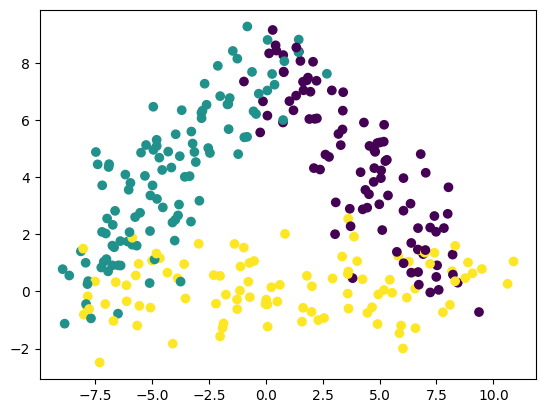

In [280]:
plt.scatter(waveform_pca[:,0],waveform_pca[:,1],c=np.squeeze(np.array(waveform_dat[['y']])))

In [283]:
wf_dat=waveform_pca[:,:2]

In [292]:
####################
####################
#      setup       #
####################
####################

# settings
K=3
steps=5000
burnin_pct=0.8
d=wf_dat.shape[1]

# initial arrays
mu0=np.array([[-3.,4.],  # blue
              [ 5.,4.],  # purple 
              [ 0.,0.]]) # yellow
sigma0=np.zeros((K,d,d))
for k in range(K): sigma0[k,:,:]=5.*np.eye(d)
w0=np.ones(K)/K

In [293]:
####################
####################
#   run sampler    #
####################
####################
seed=31415926
xs,ws,mus,sigmas=gibbs_gmm(y=wf_dat,mu0=mu0,sigma0=sigma0,w0=w0,steps=steps,burnin_pct=burnin_pct,seed=seed)

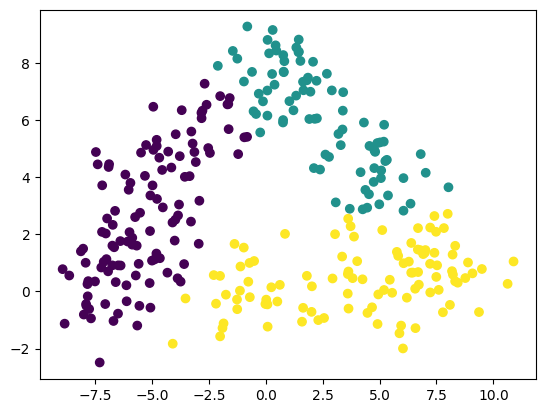

In [294]:
plt.scatter(waveform_pca[:,0],waveform_pca[:,1],c=xs[-1,:])